##Metrics

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

        
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
smooth=1.

# Rooftop Dataset

In [0]:
from google.colab import drive
drive.mount('/content/Drive')

Mounted at /content/Drive


In [0]:
with open('/content/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/gdrive/My\ Drive/foo.txt

Hello Google Drive!

##Getting Data

In [0]:
import os
import random
import sys
import warnings
import numpy as np
import pandas as pd
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.utils import Progbar

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [0]:
!ls Drive/My\ Drive/dtst2/Train/

Annotations  Roofs  Sep 3


In [0]:
train_dir="Drive/My Drive/dtst2/Train/"
test_dir='Drive//My Drive/dtst2/Test/'
num=int(len(os.listdir(train_dir+'Roofs/')))
nm=int(len(os.listdir(train_dir+'Annotations/')))
n_test=int(len(os.listdir(test_dir+'Roofs/')))

In [0]:
def get_train_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_train = np.zeros((num, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((num, IMG_HEIGHT, IMG_WIDTH,1), dtype=np.bool)

    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    """if os.path.isfile("train_img.npy") and os.path.isfile("train_mask.npy"):
        print("Train file loaded from memory")
        X_train = np.load("train_img.npy")
        Y_train = np.load("train_mask.npy")
        return X_train,Y_train
        a = Progbar(180)#length of dataset size goes in"""
    


    
##Training Satell. Images
    print('Roof Images:')
    a = Progbar(num)#length of dataset size goes in
    n=0
    for img in sorted(os.listdir(train_dir+'Roofs/')):
      img=imread(train_dir+'Roofs/'+img)
      img = resize( img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
      X_train[n] = img
      a.update(n)
      n=n+1
      
##Training Masks##
    
    print('Mask Images:')
    b = Progbar(nm)
    n=0
    a=sorted(os.listdir(train_dir+'Annotations/'))
    for fold in a:
      mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
      for mg in sorted(os.listdir(train_dir+'Annotations/'+fold)):
        mg=imread(train_dir+'Annotations/'+fold+"/"+mg)
        mg =resize(mg, (256, 256,1), mode='constant', preserve_range=True) #np.expand_dims(resize(mg, (256, 256), mode='constant', preserve_range=True),axis=-1) 
        mask = np.maximum(mask, mg)

      Y_train[n] = mask
      b.update(n)
      n=n+1
      

    np.save("train_img",X_train)
    np.save("train_mask",Y_train)
    return X_train,Y_train

In [0]:
"""a=sorted(os.listdir(train_dir+'Annotations/'))
for fold in a:
  #mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  sort=sorted(os.listdir(train_dir+'Annotations/'+fold), )
  for mg in sorted(os.listdir(train_dir+'Annotations/'+fold)) :
    print(mg)
    """

"a=sorted(os.listdir(train_dir+'Annotations/'))\nfor fold in a:\n  #mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)\n  sort=sorted(os.listdir(train_dir+'Annotations/'+fold), )\n  for mg in sorted(os.listdir(train_dir+'Annotations/'+fold)) :\n    print(mg)\n    "

In [0]:

train_img,train_mask = get_train_data()

Getting and resizing train images and masks ... 
Roof Images:
53/54 [============================>.] - ETA: 0s

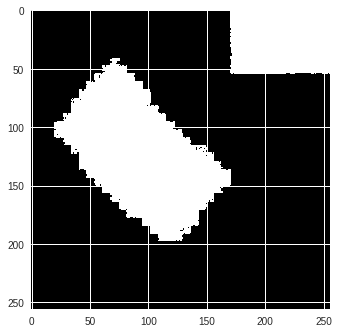

In [0]:
mg =np.squeeze(train_mask[1],axis=-1)
b=np.invert(mg)
plt.imshow(b)

###Sanity check

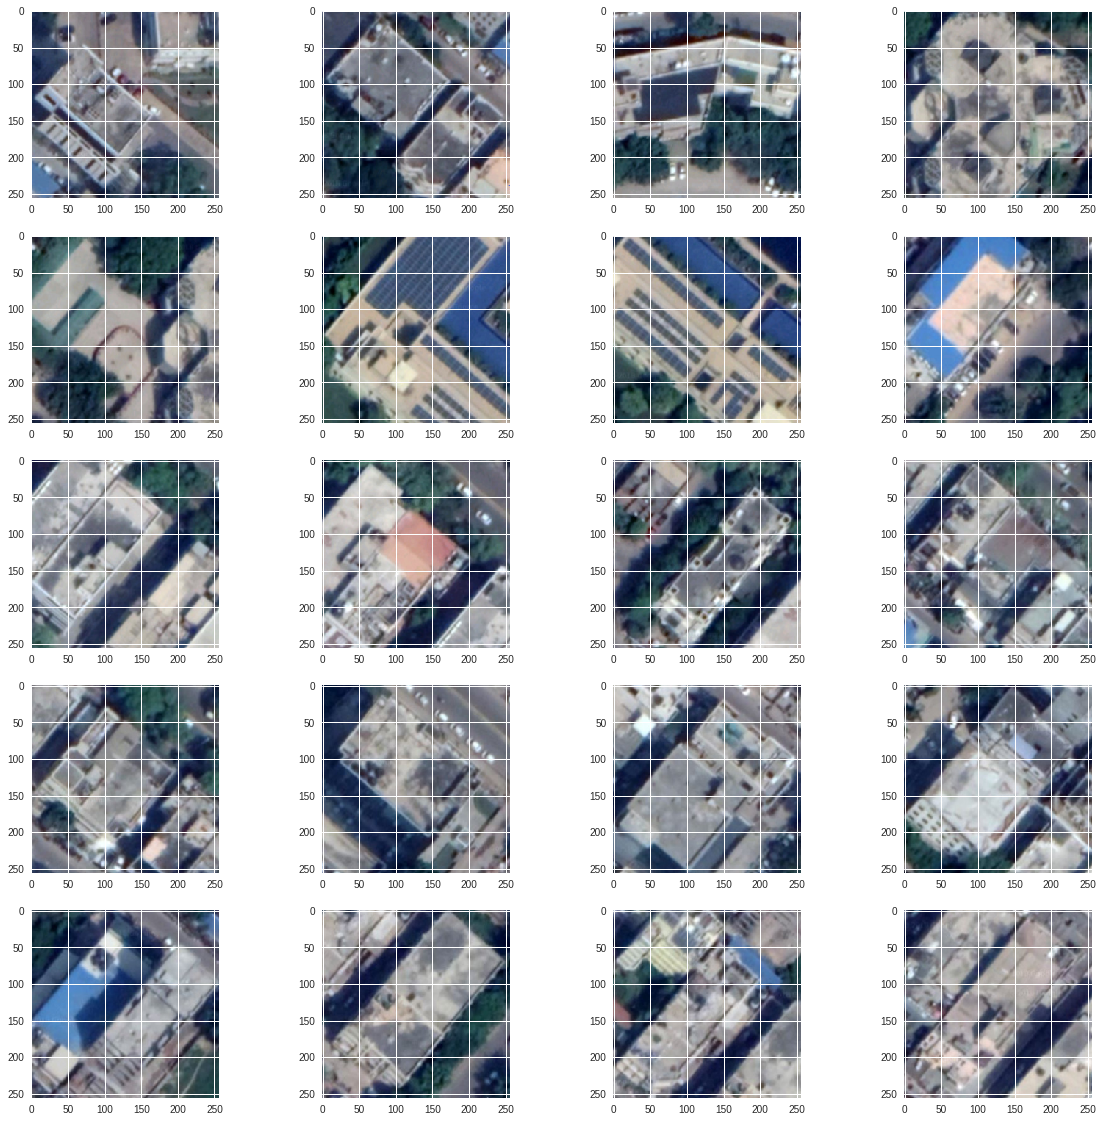

In [0]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = train_img[i]
    fig.add_subplot(rows, columns,i)
    plt.imshow(img)
plt.show()


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


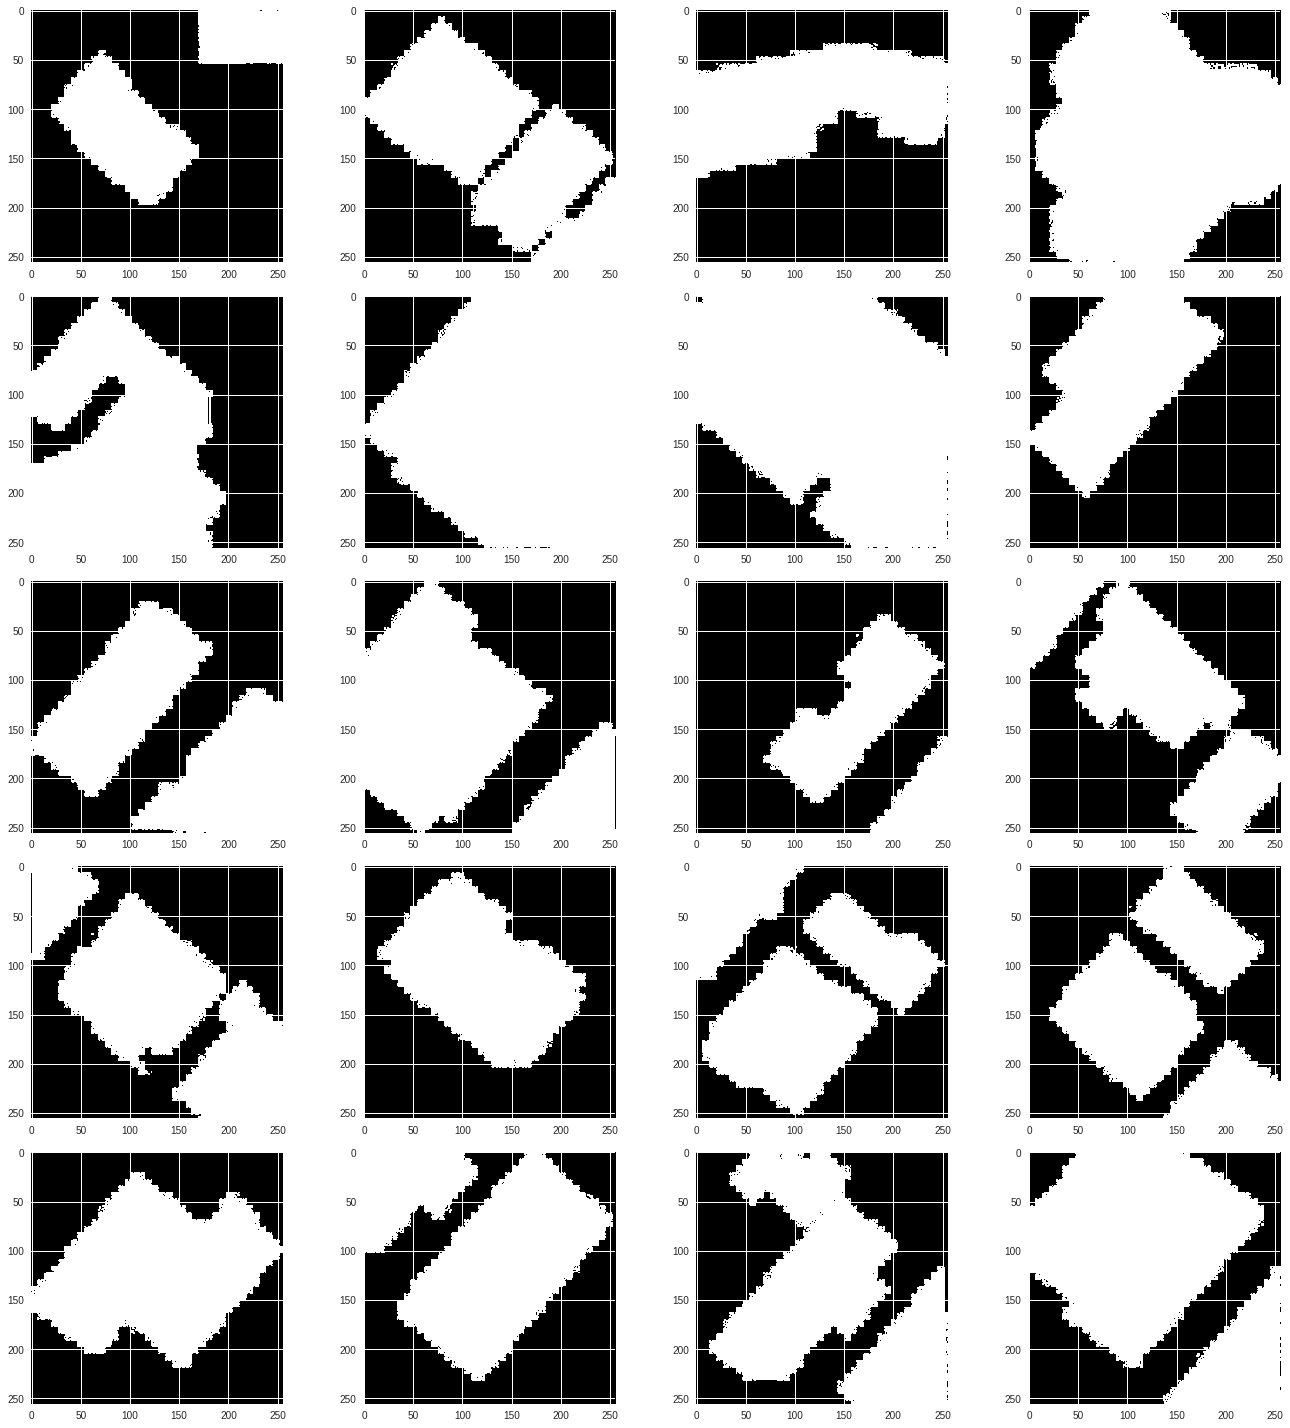

In [0]:
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    mg =np.squeeze(resize(train_mask[i], (256, 256), mode='constant', preserve_range=True),axis=-1)
    fig.add_subplot(rows, columns,i)
    #b=np.invert(mg)
    imshow(mg)
plt.show()



/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


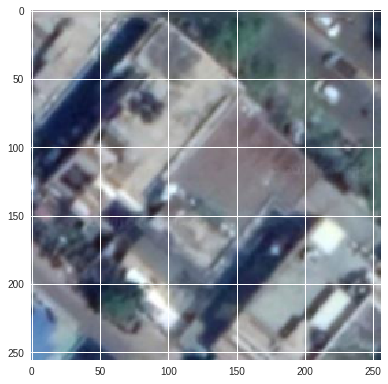

In [0]:
imshow(train_img[12])

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


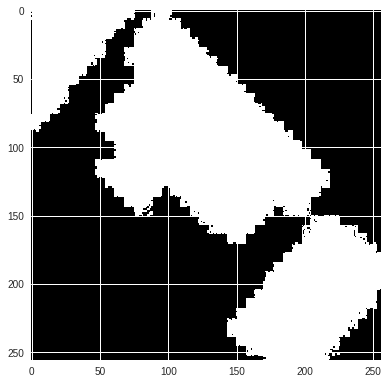

In [0]:
mg =np.squeeze(train_mask[12],axis=-1) 

imshow(mg)

##Get Test

In [0]:
def get_test(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    #X_test = np.zeros( , IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    X_test = np.zeros((n_test, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
    Y_test = np.zeros((n_test, IMG_HEIGHT, IMG_WIDTH,1), dtype=np.bool)
    print('\n Test Roof images ... ')
    sys.stdout.flush()
    
    p = Progbar(n_test)
    n=0
    for img in sorted(os.listdir(test_dir+'Roofs/')):
      img=imread(test_dir+'Roofs/'+img)
      img = resize( img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
      X_test[n] = np.squeeze(img) 
      p.update(n)
      n=n+1
      
      
      
      
    print('\n Test Mask Images:')
    print('Mask Images:')
    q = Progbar(n_test)
    n=0
    a=sorted(os.listdir(test_dir+'Annotations/'))
    for fold in a:
      mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
      for mg in sorted(os.listdir(test_dir+'Annotations/'+fold)):
        mg=imread(test_dir+'Annotations/'+fold+"/"+mg)
        mg =resize(mg, (256, 256,1), mode='constant', preserve_range=True) #np.expand_dims(resize(mg, (256, 256), mode='constant', preserve_range=True),axis=-1) 
        mask = np.maximum(mask, mg)

      Y_test[n] = mask
      q.update(n)
      n=n+1
    
    
    """b = Progbar(n_test)
    n=0
    a=sorted(os.listdir(test_dir+'mask_aug/'))
    for mg in a:
      mg=imread(test_dir+'mask_aug/'+mg)
      mg =resize(mg, (256, 256,1), mode='constant', preserve_range=True) 
      Y_test[n] = mg
      b.update(n)
      n=n+1"""
    np.save("test_img",X_test)
    np.save("test_mask",Y_test)
    return X_test,Y_test

In [0]:
test_img,test_mask= get_test()


 Test Roof images ... 
5/6 [========================>.....] - ETA: 0s
 Test Mask Images:
Mask Images:
5/6 [========================>.....] - ETA: 0s

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


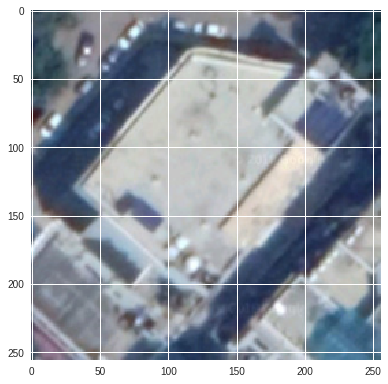

In [0]:
imshow( test_img[1])

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


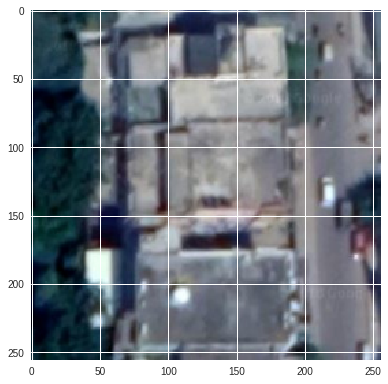

In [0]:
imshow( test_img[3])

In [0]:
np.shape(test_img_aug[3])

(256, 256, 3)

##U-net Mod

In [0]:
train_img,train_mask = get_train_data()

Getting and resizing train images and masks ... 
Roof Images:
20/21 [===========================>..] - ETA: 0s

In [0]:
train_img[4].shape

(256, 256, 4)

In [0]:
def get_unet_mod(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = Conv2D(16, (3, 3), activation= 'elu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=[dice_coef])
    model.summary()
    return model

In [0]:
u_mod=get_unet_mod()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 256, 256, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 16) 448         lambda_3[0][0]                   
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 256, 256, 16) 0           conv2d_39[0][0]                  
__________________________________________________________________________________________________
conv2d_40 

In [0]:
print("\nTraining...")
u_mod.fit(train_img,train_mask,batch_size=16,epochs=50)


Training...
Epoch 1/50
54/54 [==============================] - 8s 147ms/step - loss: 0.7143 - dice_coef: 0.5280
Epoch 2/50
54/54 [==============================] - 1s 24ms/step - loss: 0.6558 - dice_coef: 0.5509
Epoch 3/50
54/54 [==============================] - 1s 24ms/step - loss: 0.6013 - dice_coef: 0.5748
Epoch 4/50
54/54 [==============================] - 1s 24ms/step - loss: 0.7264 - dice_coef: 0.5168
Epoch 5/50
54/54 [==============================] - 1s 24ms/step - loss: 0.6875 - dice_coef: 0.6495
Epoch 6/50
54/54 [==============================] - 1s 24ms/step - loss: 0.6233 - dice_coef: 0.5918
Epoch 7/50
54/54 [==============================] - 1s 24ms/step - loss: 0.6122 - dice_coef: 0.5383
Epoch 8/50
54/54 [==============================] - 1s 24ms/step - loss: 0.6023 - dice_coef: 0.5569
Epoch 9/50
54/54 [==============================] - 1s 24ms/step - loss: 0.5957 - dice_coef: 0.5934
Epoch 10/50
54/54 [==============================] - 1s 24ms/step - loss: 0.5835 - dic

In [0]:
def get_test_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    #X_test = np.zeros( , IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    X_test = np.zeros((n_test, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []
    print('\nGetting and resizing test images ... ')
    sys.stdout.flush()
    
    a = Progbar(n_test)
    n=0
    for img in os.listdir(test_dir+'roofs/'):
      img=imread(test_dir+'roofs/'+img)
      img = resize( img, (IMG_HEIGHT, IMG_WIDTH,3), mode='constant', preserve_range=True)
      X_test[n] = img
      a.update(n)
      n=n+1
    np.save("test_img",X_test)
    np.save("test_size",sizes_test)
    return X_test,sizes_test


In [0]:
test_img,test_size=get_test_data()


Getting and resizing test images ... 
3/5 [=================>............] - ETA: 0s

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


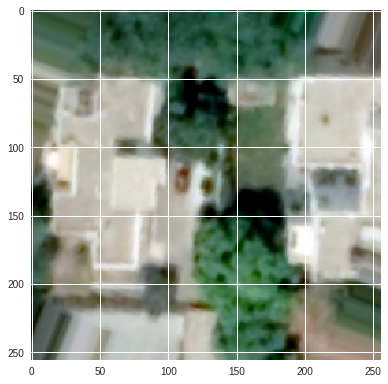

In [0]:
imshow( test_img_aug[4])

In [0]:
test_img_aug.shape

(8, 256, 256, 3)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


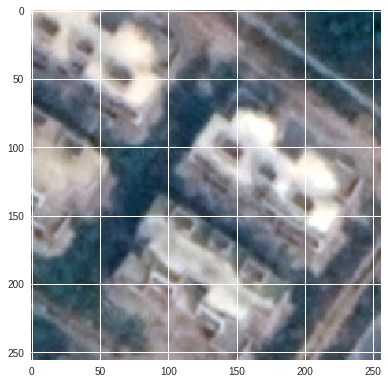

In [0]:
imshow(test_img[4])

##predictions (Modified U-Net)

In [0]:
pred_mod= u_mod.predict(test_img,batch_size=6)


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


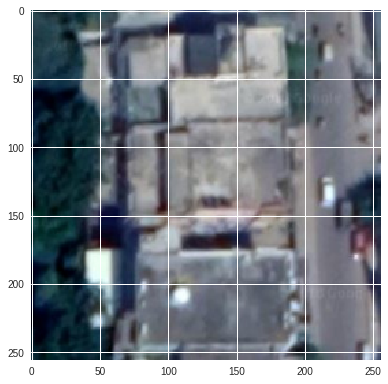

In [0]:
imshow(test_img[3])



/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


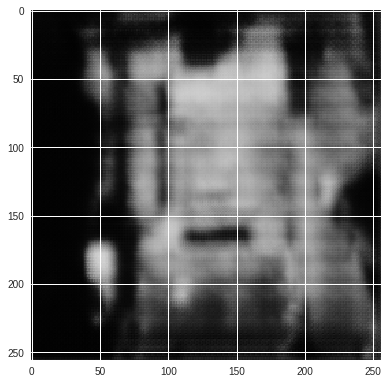

In [0]:
mg =np.squeeze( pred_mod[3],axis=-1)
imshow(mg)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


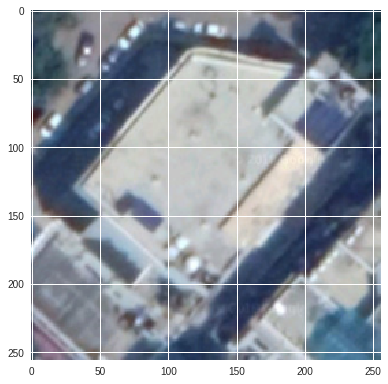

In [0]:
imshow( test_img[1])

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


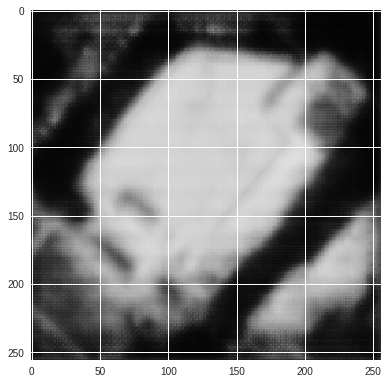

In [0]:
mg =np.squeeze( pred_mod[1],axis=-1)
imshow(mg)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


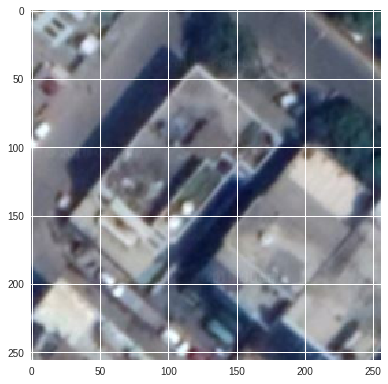

In [0]:
imshow( test_img[2] )

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


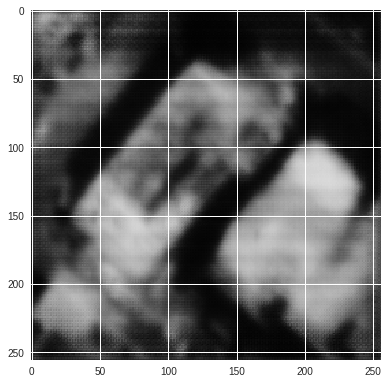

In [0]:
mg =np.squeeze( pred_mod[2],axis=-1)
imshow(mg)

##Eval (Modified U-Net)

In [0]:
u_mod.evaluate(x= test_img_aug,y= pred_mod )

8/8 [==============================] - 1s 136ms/step


[0.410014271736145, 0.6280017495155334]

In [0]:
u_mod.evaluate(x= test_img,y= pred_mod )

6/6 [==============================] - 1s 91ms/step


[0.4521176815032959, 0.566176176071167]

#Training 2nd Time

##2nd  training

In [0]:
print("\nTraining...")
u_mod.fit(train_img,train_mask,batch_size=16,epochs=25)


Training...
Epoch 1/25
54/54 [==============================] - 1s 26ms/step - loss: 0.4897 - dice_coef: 0.6789
Epoch 2/25
54/54 [==============================] - 1s 24ms/step - loss: 0.5196 - dice_coef: 0.6771
Epoch 3/25
54/54 [==============================] - 1s 24ms/step - loss: 0.4980 - dice_coef: 0.6351
Epoch 4/25
54/54 [==============================] - 1s 24ms/step - loss: 0.5216 - dice_coef: 0.6910
Epoch 5/25
54/54 [==============================] - 1s 24ms/step - loss: 0.5185 - dice_coef: 0.6136
Epoch 6/25
54/54 [==============================] - 1s 24ms/step - loss: 0.5149 - dice_coef: 0.6472
Epoch 7/25
54/54 [==============================] - 1s 24ms/step - loss: 0.5067 - dice_coef: 0.6446
Epoch 8/25
54/54 [==============================] - 1s 24ms/step - loss: 0.4861 - dice_coef: 0.6575
Epoch 9/25
54/54 [==============================] - 1s 24ms/step - loss: 0.4757 - dice_coef: 0.6751
Epoch 10/25
54/54 [==============================] - 1s 24ms/step - loss: 0.4828 - dice

## 2nd Predicitons

In [0]:
pred_mod2= u_mod.predict(test_img,batch_size=6)


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


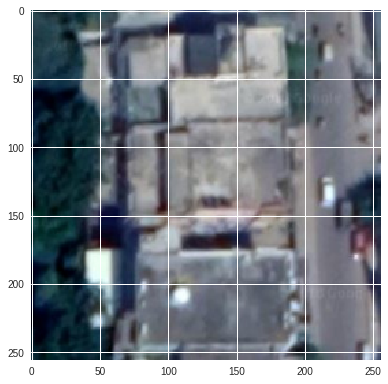

In [0]:
imshow(test_img[3])


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


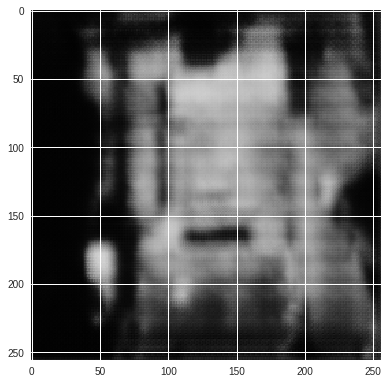

In [0]:

mg =np.squeeze( pred_mod[3],axis=-1)
imshow(mg)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


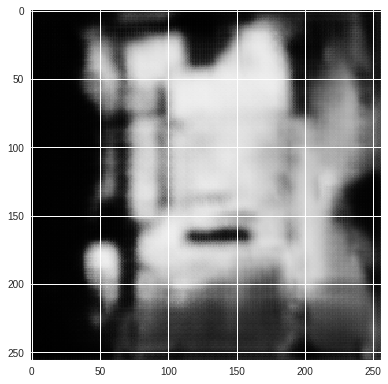

In [0]:

mg =np.squeeze( pred_mod2[3],axis=-1)
imshow(mg)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


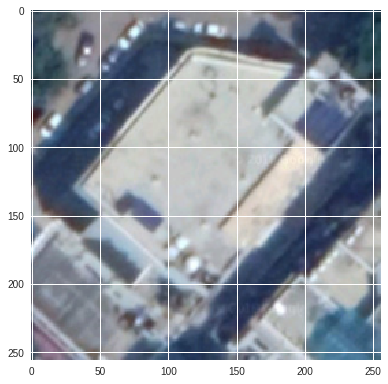

In [0]:
imshow( test_img[1] )


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


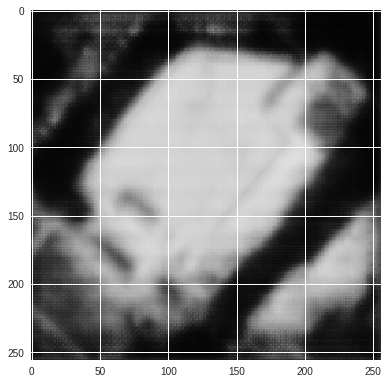

In [0]:
mg =np.squeeze( pred_mod[1],axis=-1)
imshow(mg)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


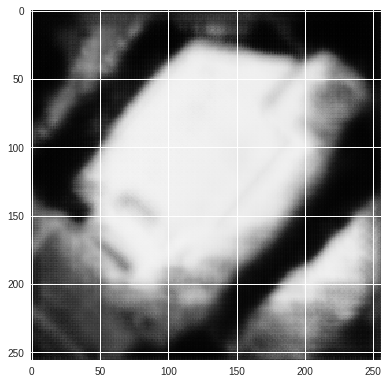

In [0]:
mg =np.squeeze( pred_mod2[1],axis=-1)
imshow(mg)

## 2nd Eval U-Net Mod

In [0]:
u_mod.evaluate(x= test_img,y= pred_mod2 )

6/6 [==============================] - 0s 13ms/step


[0.4099448621273041, 0.6918529868125916]

Validation: loss: 0.4517 - dice_coef: 0.6879

#Training 3rd Time

##3rd  training

In [0]:
u_mod3=get_unet_mod()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 256, 256, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 256, 256, 16) 448         lambda_4[0][0]                   
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 256, 256, 16) 0           conv2d_58[0][0]                  
__________________________________________________________________________________________________
conv2d_59 

In [0]:
print("\nTraining...")
u_mod3.fit(train_img,train_mask,batch_size=16,epochs=100)


Training...
Epoch 1/100
54/54 [==============================] - 3s 64ms/step - loss: 0.7064 - dice_coef: 0.5135
Epoch 2/100
54/54 [==============================] - 1s 24ms/step - loss: 0.6707 - dice_coef: 0.5683
Epoch 3/100
54/54 [==============================] - 1s 24ms/step - loss: 0.6306 - dice_coef: 0.5725
Epoch 4/100
54/54 [==============================] - 1s 24ms/step - loss: 0.6163 - dice_coef: 0.6093
Epoch 5/100
54/54 [==============================] - 1s 24ms/step - loss: 0.6056 - dice_coef: 0.5450
Epoch 6/100
54/54 [==============================] - 1s 24ms/step - loss: 0.5824 - dice_coef: 0.6104
Epoch 7/100
54/54 [==============================] - 1s 24ms/step - loss: 0.5883 - dice_coef: 0.6117
Epoch 8/100
54/54 [==============================] - 1s 24ms/step - loss: 0.5762 - dice_coef: 0.6094
Epoch 9/100
54/54 [==============================] - 1s 24ms/step - loss: 0.5608 - dice_coef: 0.6120
Epoch 10/100
54/54 [==============================] - 1s 24ms/step - loss: 0.5

## 3rd Predicitons

In [0]:
pred_mod3= u_mod3.predict(test_img,batch_size=6)


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


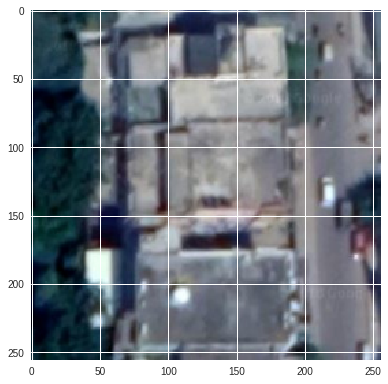

In [0]:
imshow(test_img[3])


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


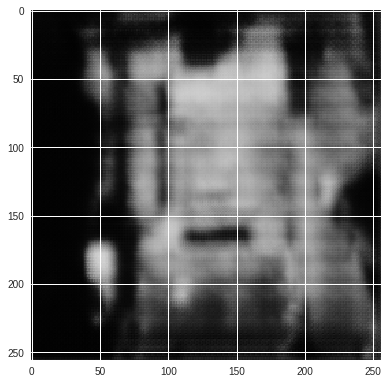

In [0]:

mg =np.squeeze( pred_mod[3],axis=-1)
imshow(mg)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


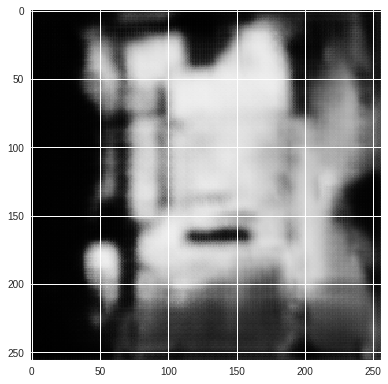

In [0]:

mg =np.squeeze( pred_mod2[3],axis=-1)
imshow(mg)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


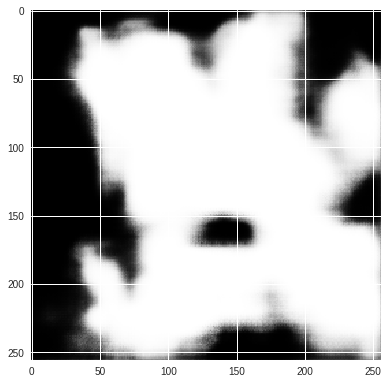

In [0]:

mg =np.squeeze( pred_mod3[3],axis=-1)
imshow(mg)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


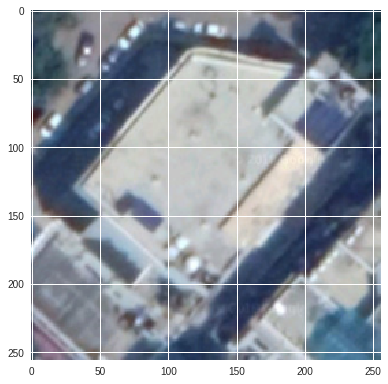

In [0]:
imshow( test_img[1] )


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


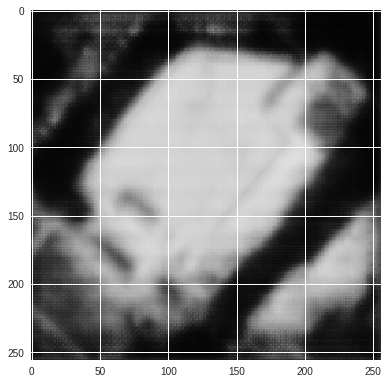

In [0]:
mg =np.squeeze( pred_mod[1],axis=-1)
imshow(mg)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


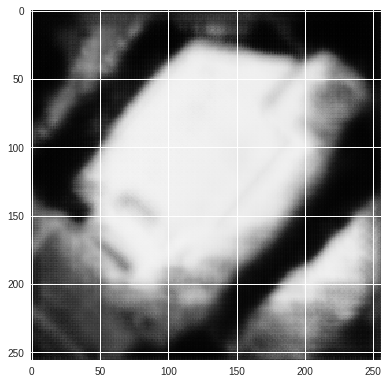

In [0]:
mg =np.squeeze( pred_mod2[1],axis=-1)
imshow(mg)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


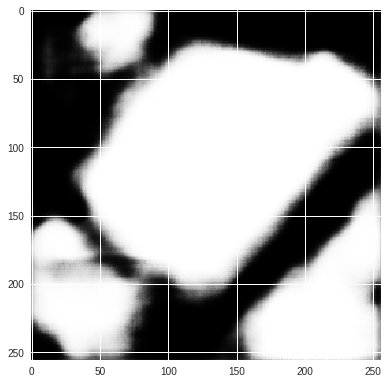

In [0]:

mg =np.squeeze( pred_mod3[1],axis=-1)
imshow(mg)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


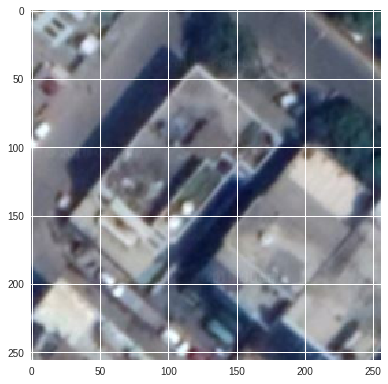

In [0]:
imshow( test_img[2] )



/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


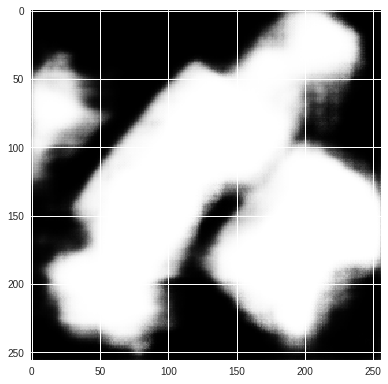

In [0]:
mg =np.squeeze( pred_mod3[2],axis=-1)
imshow(mg)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


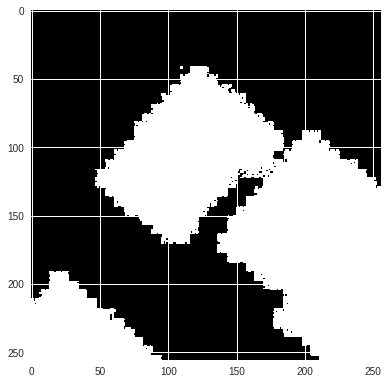

In [0]:
mg =np.squeeze( test_mask[2],axis=-1)
imshow(mg)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


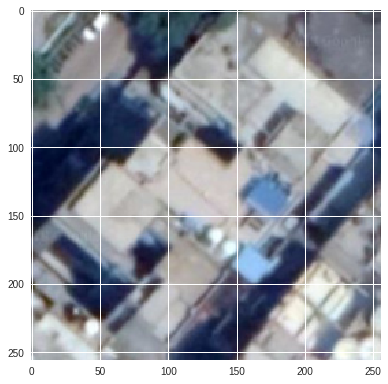

In [0]:
imshow( test_img[4] )



/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


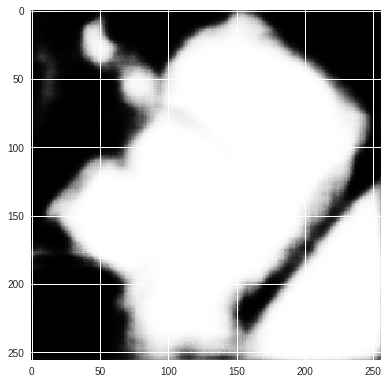

In [0]:
mg =np.squeeze( pred_mod3[4],axis=-1)
imshow(mg)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


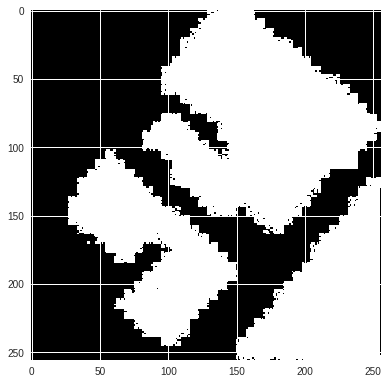

In [0]:
mg =np.squeeze( test_mask[4],axis=-1)
imshow(mg)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


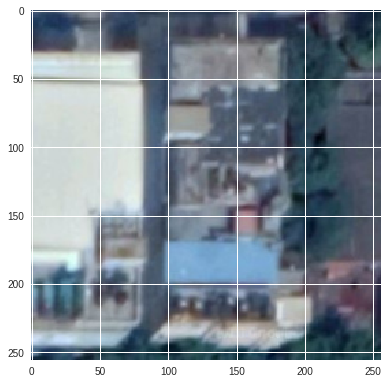

In [0]:
imshow( test_img[5] )


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


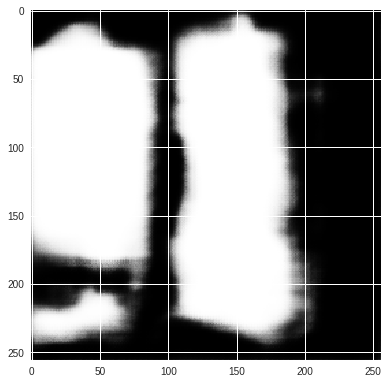

In [0]:

mg =np.squeeze( pred_mod3[5],axis=-1)
imshow(mg)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


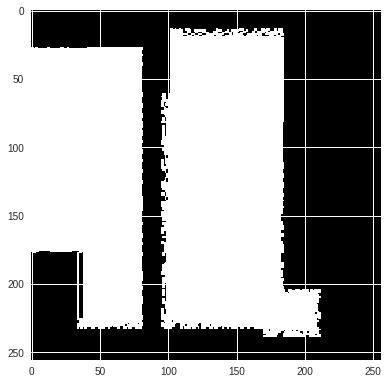

In [0]:
mg =np.squeeze( test_mask[5],axis=-1)
imshow(mg)

In [0]:
imshow( test_img[3] )

mg =np.squeeze( pred_mod3[3],axis=-1)
imshow(mg)

## 3rd Eval U-Net Mod

In [0]:
u_mod.evaluate(x= test_img,y= pred_mod2 )

6/6 [==============================] - 0s 13ms/step


[0.4099448621273041, 0.6918529868125916]

Validation: loss: 0.4517 - dice_coef: 0.6879
*The above results were after second training*

In [0]:
u_mod3.evaluate(x= test_img,y= pred_mod3 )

6/6 [==============================] - 1s 95ms/step


[0.12806737422943115, 0.9342598915100098]

*The results at the end of 3rd training were-->* l**oss: 0.0906 - dice_coef: 0.9431**